In [1]:
%clear
import tensorflow as tf
import numpy as np
import argparse
import socket
import importlib
import time
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

import scipy.misc
import sys
BASE_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(BASE_DIR) +'/pointnet2-master'
sys.path.append(BASE_DIR)
sys.path.append(ROOT_DIR)
print('BASE_DIR =' ,BASE_DIR)
print('ROOT_DIR =' ,ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
sys.path.append(os.path.join(ROOT_DIR, 'part_seg'))
import provider
import copy
import modelnet_dataset
import modelnet_h5_dataset
import my_data_import as chao_data_import
import EvaluationFunction as Evaluate

BASE_DIR = /home/chaotang/文档/Try
ROOT_DIR = /home/chaotang/文档/pointnet2-master


# Define Utility function

In [2]:
def draw_pointcloud(batch_data):
    plt.figure()
    x,y,z = batch_data[:,0],batch_data[:,1],batch_data[:,2]
    ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
    ax.scatter(x,y,z,c = 'r',s = 1)
def get_batch(dataset, idxs, start_idx, end_idx):
    bsize = end_idx-start_idx
    batch_data = np.zeros((bsize, NUM_POINT, 6))
    batch_label = np.zeros((bsize, NUM_POINT), dtype=np.int32)
    for i in range(bsize):
        ps,normal,seg = dataset[idxs[i+start_idx]]
        batch_data[i,:,0:3] = ps
        batch_data[i,:,3:6] = normal
        batch_label[i,:] = seg
    return batch_data, batch_label

# Get the partSeg model

part_MODEL_PATH /home/chaotang/文档/pointnet2-master/part_seg/log_part_withoutNorm/model.ckpt


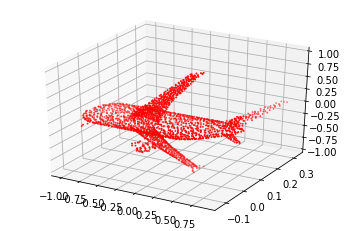

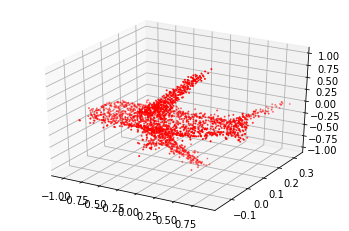

In [38]:
BATCH_SIZE = 16
NUM_POINT = 2048
PART_SEG_DIR = ROOT_DIR + '/part_seg'
MODEL_PATH_part = PART_SEG_DIR + '/log_part_withoutNorm/model.ckpt'
print('part_MODEL_PATH',MODEL_PATH_part)

GPU_INDEX = 0
part_MODEL = importlib.import_module('pointnet2_part_seg') # import network module

test_index = 12

# Get Train data
batch_data = np.zeros((BATCH_SIZE, NUM_POINT, 6))    ### shape = (16,2048,6)
batch_label = np.zeros((BATCH_SIZE, NUM_POINT)).astype(np.int32)

batch_data[:,:,0:3],batch_label = chao_data_import.get_data()


Original_pl = batch_data[test_index][:,0:3]
Nosise_batch = np.zeros((BATCH_SIZE, NUM_POINT, 6))
Nosise_batch = copy.copy(batch_data)

k = 1000
#Noisy_pl[test_index,0:k,0:3] = Original_pl[test_index,0:k,:] + 0.025 * np.random.normal(size = (k,3))# Noisy的点云

Nosise_batch[:,0:k,0:3] += 0.025 * np.random.normal(size = (BATCH_SIZE,k,3))# Noisy的点云
Noise_pl = Nosise_batch[test_index]

########################################
########### Visualization ##############
########################################
draw_pointcloud(Original_pl)
draw_pointcloud(Noise_pl)

# Part Segmentation为下一步分类进行识别
batch_data: 干净的点云  
Nosise_batch: 噪音级高的点云

In [39]:
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
VOTE_NUM = 6
is_training = False

pointclouds_pl = tf.placeholder(dtype = tf.float32, shape=(BATCH_SIZE, NUM_POINT, 6))

labels_pl = tf.placeholder(tf.int32, shape=(BATCH_SIZE, BATCH_SIZE))
is_training_pl = tf.placeholder(tf.bool, shape=())

pred, end_points = part_MODEL.get_model(pointclouds_pl, is_training_pl)
saver = tf.train.Saver()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
with tf.Session(config=config) as sess:
    # Restore variables from disk.
    saver.restore(sess, MODEL_PATH_part)
    print('Model restored!!!!!')
    pred_val = np.zeros((BATCH_SIZE, NUM_POINT, 50))# (16*2048*50)
    pred_val2 = np.zeros((BATCH_SIZE, NUM_POINT, 50))# (16*2048*50)
    for _ in range(VOTE_NUM):
        feed = {pointclouds_pl:batch_data,is_training_pl:is_training}# No noise
        feed2 = {pointclouds_pl:Nosise_batch,is_training_pl:is_training}# Noise Feed in
        
        temp_pred_val,endpoints = sess.run([pred,end_points],feed_dict = feed)
        temp_pred_val2,endpoints2 = sess.run([pred,end_points],feed_dict = feed2)
        
        pred_val += temp_pred_val
        pred_val2 += temp_pred_val2
        
    pred_val /= float(VOTE_NUM)
    pred_val2 /= float(VOTE_NUM)
    
    print('Calculation Done!!!')

INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/part_seg/log_part_withoutNorm/model.ckpt
Model restored!!!!!
Calculation Done!!!


# 将partseg 的分类结果转换为each point label，并visualization


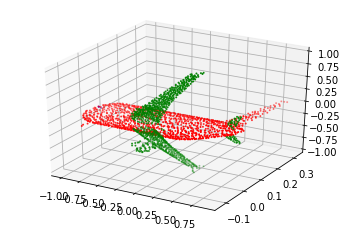

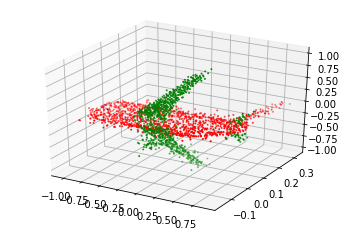

In [40]:
CPoint_label = pred_val[:,:,0:4]
NPoint_label = pred_val2[:,:,0:4]
CPoint_label = np.argmax(CPoint_label,axis = 2)
NPoint_label = np.argmax(NPoint_label,axis = 2)

combine_data_c = np.zeros((BATCH_SIZE, NUM_POINT, 4)) # shape = (16,2048,4) point(x,y,z,label)
combine_data_n = np.zeros((BATCH_SIZE, NUM_POINT, 4))

combine_data_c[:,:,0:3] = batch_data[:,:,0:3]
combine_data_n[:,:,0:3] = Nosise_batch[:,:,0:3]
combine_data_c[:,:,3] = CPoint_label
combine_data_n[:,:,3] = NPoint_label
################################################
############# Visualization ####################
###############################################
plt.figure()
ax = plt.subplot(111,projection='3d')  # 创建一个三维的绘图工程
colors = ['r','g','b','k','orange','magenta'] # 定义颜色，一个分类 最多 6 个分类因此最多6种颜色
for index in range(6):
    x = combine_data_c[test_index,combine_data_c[test_index,:,3]==index][:,0]
    y = combine_data_c[test_index,combine_data_c[test_index,:,3]==index][:,1]
    z = combine_data_c[test_index,combine_data_c[test_index,:,3]==index][:,2]
    
    ax.scatter(x,y,z,c = colors[index],s = 1)
    
plt.figure()
ax = plt.subplot(111,projection='3d')  # 创建一个三维的绘图工程
colors = ['r','g','b','k','orange','magenta'] # 定义颜色，一个分类 最多 6 个分类因此最多6种颜色
for index in range(6):
    x_n = combine_data_n[test_index,combine_data_c[test_index,:,3]==index][:,0]
    y_n = combine_data_n[test_index,combine_data_c[test_index,:,3]==index][:,1]
    z_n = combine_data_n[test_index,combine_data_c[test_index,:,3]==index][:,2]
    
    ax.scatter(x_n,y_n,z_n,c = colors[index],s = 1)